In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Conv1D, MaxPooling1D, Flatten
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [10]:
finalData = pd.read_csv("AAPL_processed.csv")
finalData.set_index('DateTime',inplace=True)  
cols = finalData.columns.tolist()
cols = cols[-1:] + cols[:-1]
finalData = finalData[cols]

In [11]:
# Example: Create sentiment text from the sentiment score
def create_sentiment_text(row):
    if row['Sentiment_score'] > 0.1:
        return "positive sentiment"
    elif row['Sentiment_score'] < 0.1:
        return "negative sentiment"
    else:
        return "neutral sentiment"

# Add a text column to your data
finalData['Sentiment_text'] = finalData.apply(create_sentiment_text, axis=1)

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
finalData['Normalized_Price'] = scaler.fit_transform(finalData[['Price']])

# Tokenize the text at the character level
tokenizer = Tokenizer(char_level=True)  # Character-level tokenizer
tokenizer.fit_on_texts(finalData['Sentiment_text'])
sequences = tokenizer.texts_to_sequences(finalData['Sentiment_text'])

# Pad sequences to the same length
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Step 5: Split data into training and testing sets
n_train_hours = int(len(finalData) * 0.7)  # 70% train, 30% test
train_X = padded_sequences[:n_train_hours]
test_X = padded_sequences[n_train_hours:]
train_y = finalData['Normalized_Price'][:n_train_hours].values
test_y = finalData['Normalized_Price'][n_train_hours:].values



In [13]:
# Step 6: Reshape data for LSTM input
train_X = np.expand_dims(train_X, axis=2)
test_X = np.expand_dims(test_X, axis=2)

# Step 7: Define the LSTM model with character-level embedding
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size (unique characters + 1)
embedding_dim = 10  # Embedding dimensions

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    LSTM(50, return_sequences=False),  # LSTM for temporal patterns
    Dense(1)  # Output layer
])
model.compile(loss='mae', optimizer='adam')

In [14]:
# Step 8: Train the model
history = model.fit(
    train_X, train_y,
    epochs=50,  # Adjust based on your data size
    batch_size=4,  # Small batches for stable training
    validation_data=(test_X, test_y),
    verbose=2
)

Epoch 1/50
58/58 - 1s - loss: 0.1505 - val_loss: 0.4745 - 1s/epoch - 24ms/step
Epoch 2/50
58/58 - 0s - loss: 0.0903 - val_loss: 0.4879 - 181ms/epoch - 3ms/step
Epoch 3/50
58/58 - 0s - loss: 0.0892 - val_loss: 0.4720 - 177ms/epoch - 3ms/step
Epoch 4/50
58/58 - 0s - loss: 0.0872 - val_loss: 0.4057 - 177ms/epoch - 3ms/step
Epoch 5/50
58/58 - 0s - loss: 0.0913 - val_loss: 0.4907 - 175ms/epoch - 3ms/step
Epoch 6/50
58/58 - 0s - loss: 0.0941 - val_loss: 0.4742 - 175ms/epoch - 3ms/step
Epoch 7/50
58/58 - 0s - loss: 0.0949 - val_loss: 0.4745 - 172ms/epoch - 3ms/step
Epoch 8/50
58/58 - 0s - loss: 0.0884 - val_loss: 0.4495 - 173ms/epoch - 3ms/step
Epoch 9/50
58/58 - 0s - loss: 0.0876 - val_loss: 0.4789 - 175ms/epoch - 3ms/step
Epoch 10/50
58/58 - 0s - loss: 0.0897 - val_loss: 0.4733 - 173ms/epoch - 3ms/step
Epoch 11/50
58/58 - 0s - loss: 0.0886 - val_loss: 0.4612 - 172ms/epoch - 3ms/step
Epoch 12/50
58/58 - 0s - loss: 0.0867 - val_loss: 0.5168 - 175ms/epoch - 3ms/step
Epoch 13/50
58/58 - 0s - lo

In [15]:
# Step 9: Evaluate the model
predictions = model.predict(test_X)
predictions_rescaled = scaler.inverse_transform(predictions)  # Rescale to original prices
test_y_rescaled = scaler.inverse_transform(test_y.reshape(-1, 1))

# Calculate evaluation metrics
mae = mean_absolute_error(test_y_rescaled, predictions_rescaled)
rmse = mean_squared_error(test_y_rescaled, predictions_rescaled, squared=False)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

4/4 [==============================] - 0s 2ms/step
Mean Absolute Error (MAE): 47.26
Root Mean Squared Error (RMSE): 48.17


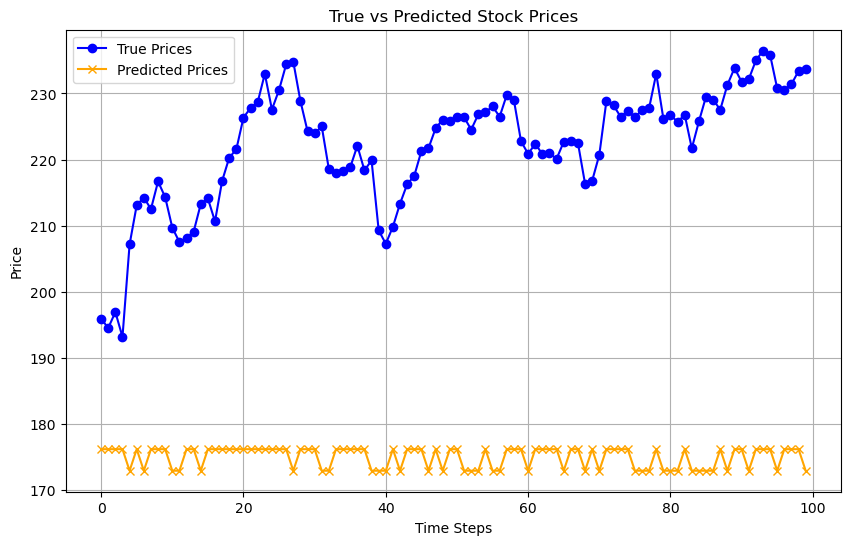

In [16]:
# Step 10: Visualize results

plt.figure(figsize=(10, 6))
plt.plot(test_y_rescaled, label="True Prices", color="blue", marker="o")
plt.plot(predictions_rescaled, label="Predicted Prices", color="orange", marker="x")
plt.title("True vs Predicted Stock Prices")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

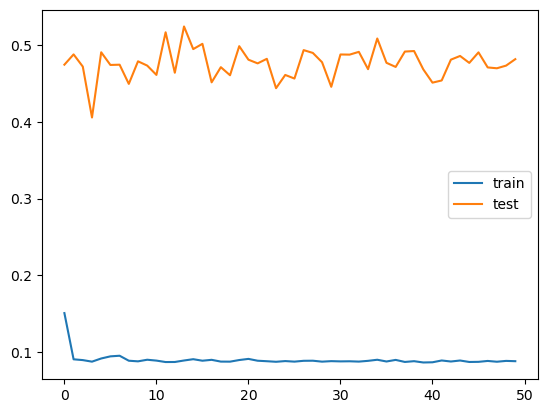

In [17]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()